In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.precision', 6)
pd.set_option('display.width', 1000)

# Backward Cauchy's Euler

## Algorithm

- Input
  * **Vector Function:** $\mathbf{F}(x, \mathbf{Y})$.
  * **Initial State:** $x_0, \mathbf{Y}_0$.
  * **Interval:** $[x_0, X]$.
  * **Step count:** $N$.
  * **Tolerance:** $\epsilon$ (e.g., $10^{-6}$).

- Steps
1.  **Initialize:** $x_{curr} = x_0, \mathbf{Y}_{curr} = \mathbf{Y}_0, h = (X - x_0)/N$.

2.  **Time Loop** (for $j = 0$ to $N-1$):
    * **Step Setup:** $x_{next} = x_{curr} + h$.
    
    * **Predictor (Guess):**
        * Estimate $\mathbf{Y}^{(0)}$ using Forward Euler:
          $$\mathbf{Y}^{(0)} = \mathbf{Y}_{curr} + h \cdot \mathbf{F}(x_{curr}, \mathbf{Y}_{curr})$$
    
    * **Inner Solver (Fixed-Point Iteration):**
        * Loop $k = 0, 1, \dots, max\_iter$:
            * Calculate slope at guess: $\mathbf{K} = \mathbf{F}(x_{next}, \mathbf{Y}^{(k)})$
            * Update guess:
              $$\mathbf{Y}^{(k+1)} = \mathbf{Y}_{curr} + h \cdot \mathbf{K}$$
            * Check Convergence:
              If $\|\mathbf{Y}^{(k+1)} - \mathbf{Y}^{(k)}\|_{\infty} < \epsilon$, stop.
    
    * **Update:** $\mathbf{Y}_{curr} = \mathbf{Y}^{(final)}$.

- Output
  * A sequence of vectors $\mathbf{Y}_j$ that is highly stable, making it suitable for stiff differential equations.

In [23]:
def backward_euler_system_solver(F, x0, Y0, X_end, N, tol=1e-6, max_iter=50):
    """
    Solves a system Y' = F(x, Y) using the Backward Euler method.
    Formula: Y_{n+1} = Y_n + h * F(x_{n+1}, Y_{n+1})
    
    Since Y_{n+1} is on the right side, we use Fixed-Point Iteration 
    to solve for it at every step.
    
    Parameters:
    F : function
        Vector function F(x, Y) -> returns numpy array of derivatives
    x0 : float
        Initial x
    Y0 : list/array
        Initial state vector Y
    X_end : float
        Target x
    N : int
        Number of steps
    tol : float
        Convergence tolerance for the inner loop
    max_iter : int
        Maximum iterations for the inner loop
    """
    
    # 1. Setup
    h = (X_end - x0) / N
    Y_curr = np.array(Y0, dtype=float)
    x_curr = x0
    
    # Storage
    results = []
    
    # Store Initial Condition
    row = {'t': x_curr}
    for i, val in enumerate(Y_curr):
        row[f'y_{i}'] = val
    results.append(row)
    
    # print(f"Backward Euler Initialized. Range: [{x0}, {X_end}], h: {h}")
    
    # 2. Iteration Loop (Time Stepping)
    for j in range(N):
        x_next = x_curr + h
        
        # --- Implicit Solver (Inner Loop) ---
        
        # A. Predictor: Use Forward Euler to get a good initial guess
        # This speeds up convergence significantly compared to guessing Y_curr
        K_pred = np.array(F(x_curr, Y_curr))
        Y_guess = Y_curr + h * K_pred
        
        # B. Corrector: Fixed-Point Iteration
        # We iterate Y = Y_prev + h * F(x_next, Y) until Y stops changing
        for k in range(max_iter):
            # Calculate slope at the guessed future point
            K_implicit = np.array(F(x_next, Y_guess))
            
            # Apply Backward Euler Formula
            Y_new = Y_curr + h * K_implicit
            
            # Check for convergence (Matrix Norm)
            # We check the maximum difference across all vector components
            error = np.max(np.abs(Y_new - Y_guess))
            
            # Update guess
            Y_guess = Y_new
            
            if error < tol:
                break
        
        # C. Update State
        Y_curr = Y_guess
        x_curr = x_next
        
        # Store results
        row = {'t': x_curr}
        for i, val in enumerate(Y_curr):
            row[f'y_{i}'] = val
        results.append(row)

    return pd.DataFrame(results)

## Result

In [24]:
# --- Usage Example: Stiff System ---
# Backward Euler is famous for handling "Stiff" equations where other methods fail.
# System: 
# y' = -20y  (Decays very fast)
# z' = y + z (Coupled)

def stiff_system(t, Y):
    y = Y[0]
    z = Y[1]
    
    dy = -20 * y
    dz = y + z
    return [dy, dz]

# Parameters
t_start = 0
Y_start = [1.0, 0.0] # y=1, z=0
t_stop = 1.0
steps = 20 # Step size h=0.05. Forward Euler would be unstable here!

In [25]:
# Run
df_backward = backward_euler_system_solver(stiff_system, t_start, Y_start, t_stop, steps)
df_backward

,t,y_0,y_1
0,0.00,1.0,0.000000
1,0.05,0.0,0.050125
2,0.10,0.0,0.052763
3,0.15,0.0,0.055540
4,0.20,0.0,0.058464
5,0.25,0.0,0.061541
6,0.30,0.0,0.064780
7,0.35,0.0,0.068189
8,0.40,0.0,0.071778
9,0.45,0.0,0.075556


## Visualize

In [26]:
def plot_solver_result(df, mode, col1='x', col2='y_0', output_file='plot.png'):
    """
    Visualizes the solver output.
    
    Parameters:
    df : pd.DataFrame
        The solution table.
    mode : int
        1 for Time Series (x vs y).
        2 for Phase Plot (y_i vs y_j).
    col1 : str
        Name of the column for the X-axis.
    col2 : str
        Name of the column for the Y-axis.
    output_file : str
        Filename to save the image.
    """
    plt.figure(figsize=(10, 6))
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot Logic
    for item in col2:
        plt.plot(df[col1], df[item], label=f'{item} vs {col1}', linewidth=2, )
        plt.xlabel(col1, fontsize=12)
        plt.ylabel(item, fontsize=12)
    # Formatting
    plt.legend()
    
    if mode == 1:
        # Set the axis limits manually
        #plt.xlim(-10, 2000)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 1: Time Series Plot ({col1} vs {col2})", fontsize=14)

    elif mode == 2:
        # Set the axis limits manually
        #plt.xlim(-10, 250)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 2: Phase Plane Plot ({col1} vs {col2})", fontsize=14)

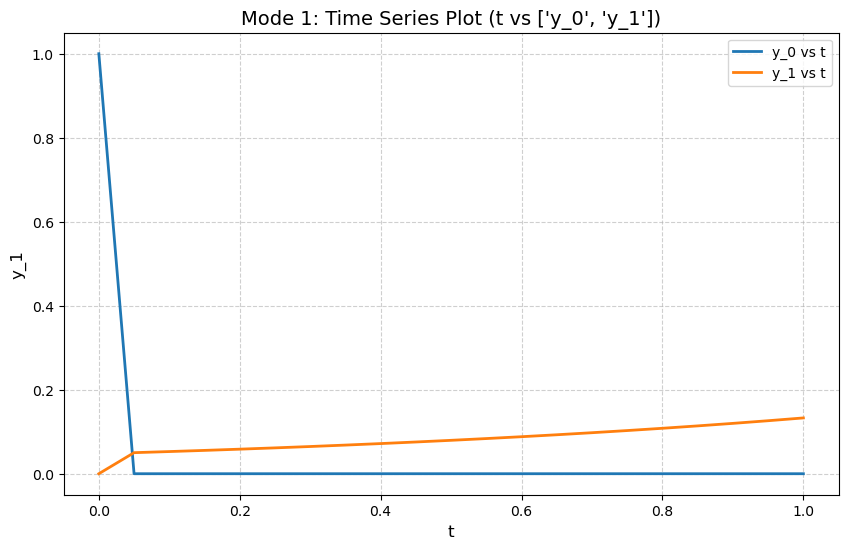

In [27]:
plot_solver_result(df_backward, mode=1, col1='t', col2=['y_0', 'y_1'])
